In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle
import os
from nltk import FreqDist
from PIL import Image
from nltk.corpus import PlaintextCorpusReader as pcr

from wordcloud import WordCloud
import community
from importlib import reload 
reload(community)


import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus

import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

In [2]:
# Load the character dataframe 
characters_df = pd.read_csv('data/characters.csv')

# Load the network 
with open('data/SW_DG_GCC.gpickle', 'rb') as handle:
    SW_DG_GCC = pickle.load(handle)
with open('data/SW_DG_GCC.gpickle', 'rb') as handle:
    SW_DG_GCC = pickle.load(handle)

# Create to undirected graph for plot
G_SW_GCC = SW_DG_GCC.to_undirected()

# Load the partition 
with open('data/partition.pickle', 'rb') as handle:
    partition = pickle.load(handle)

with open('data/wiki.pickle', 'rb') as handle:
    wiki = pickle.load(handle)

with open('data/dict_LabMT.pickle', 'rb') as handle:
    dict_LabMT = pickle.load(handle)

with open('data/dict_VADER.pickle', 'rb') as handle:
    dict_VADER = pickle.load(handle)


# Word clouds

The word clouds help us extract meaning from large amounts of text by providing the most descriptive words in a document or corpus. We are extracting the most descriptive words based on two functions the Term Count (TC) and Inverse Document Frequency (IDF). TC function returns how many times a specific term (word) appears in a given document. IDF function returns a value related to how many documents in a corpus a specific term (word) appears. The output of the TC function can be described as how important a term is in a document. The output of the IDF function can be described as how unique the term in the corpus is. By multiplying both outputs we acquire the most descriptive words for a document.

## Word clouds for alliance based on the wiki

In [3]:
#Remove the characters with no alliance
characters_dropna = characters_df.dropna()

In [4]:
corpus_root = os.getcwd() + '/data/characters/'
file_list = characters_dropna['File_Name'] + '.txt'
corpus = pcr(corpus_root, file_list)

In [5]:
list_alliance = list(set(characters_dropna['Alliance']))

In [6]:
#Create Corpus for alliance
corpus_root_alliance = os.getcwd() + '/data/Alliance/'
file_list_alliance = pd.Series(list_alliance) + '.txt'
corpus_alliance = pcr(corpus_root_alliance, file_list_alliance)

In [7]:
def create_wordclouds(data):
    #The if statement filter the object between a corpus and a dictionary
    if type(data) == dict:
        tc_dict = {document:{term:term_count for term,term_count in FreqDist(data[document]).most_common()} for document in data.keys()}
    else:
        tc_dict = {document:{term:term_count for term,term_count in FreqDist(data.words(document)).most_common()} for document in data.fileids()}
    
    #Dictionary with IDF values for each unique word
    idf_dict = {}
    for term in set([term for i in tc_dict.keys() for term in tc_dict[i].keys()]):
        N = len(tc_dict.keys()) #Total number of words inside document
        nt = 0 
        for d in tc_dict.keys():
            if term in tc_dict[d].keys():
                nt += 1 # nt describes in how many documents the term appears
        idf_dict[term] = round(np.log(N/nt),4) #Calculate Inverse Term Frequency
    
    #Dictionary with TC-IDF values for each word for each document
    tc_idf_dict = {document:{term:tc_dict[document].get(term)*idf_dict.get(term) for term in tc_dict[document].keys()}\
         for document in tc_dict.keys()}
    
    #Dictionary with TC-IDF values of the top 200 words for each docoment
    most_common_dict = {document:{word:value for word,value in sorted(tc_idf_dict[document].items(),\
         key=lambda item: item[1],reverse=True)[:200]} for document in tc_dict.keys()}
    

    #Create wordclouds
    col_word = ['Reds', 'Purples', 'BuGn', 'Blues', 'Greens'] #Colormap
    mask = np.array(Image.open(os.getcwd() + '/data/Stormtrooper.jpg')) #Create shape image for wordclouds
    a = 0

    #Plotting the word cloud
    plt.figure(figsize=[16, 24])
    for attribute in most_common_dict.keys():
        plt.subplot(3, 2, a+1)
        wordcloud = WordCloud(mask=mask, collocations = False, background_color="white", colormap=col_word[a],\
             max_font_size=1024, relative_scaling = 0.6, max_words = 200, 
        width = 3000, height = 3000).generate_from_frequencies(most_common_dict[attribute])
        
        a+=1
        plt.imshow(wordcloud,interpolation="bilinear")
        plt.axis("off")
        attribute_clean = str(attribute).replace('.txt','')
        plt.title(f'{attribute_clean}', fontsize=30)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

In [2]:
# Have troble plotting the word cloud for the wepage, but it works locally, thus we upload an image of it 
#create_wordclouds(corpus_alliance)

![alliance](data/alliance_wc.PNG)

As we observe from the evil alliance we can see names from evil characters such as General Hux which was the leader of the First Order. 

Surprisingly General Kenobi appears on the sith word cloud which is unusual because he is a Jedi, but he had a lot of interactions with Sith lords, thus his appearance on the wordcloud is justified. 

The word "Squadron" appearing in the "Good" word cloud, which is the fighting unit of TIE fighters. 

Finally, for the Jedi word cloud we can see the characters such as a known Jedi [Shaak Ti](https://starwars.fandom.com/wiki/Shaak_Ti) and General [Mace Windu](https://starwars.fandom.com/wiki/Mace_Windu), but surprisingly we can also see relatives of the Jedis such as [Morgan Elsbeth](https://starwars.fandom.com/wiki/Morgan_Elsbeth) which we found her appearance in the Jedi word cloud surprising after her duels with [Ashoka Tano](https://starwars.fandom.com/wiki/Ahsoka_Tano) and [Mandalorian](https://starwars.fandom.com/wiki/Din_Djarin) on the Star Wars Series "The Mandalorian".

## Word clouds for 5 main characters based on wiki

In [ ]:
list_top_5 = [row['File_Name'] for i,row in characters_df.iterrows() if 'Human' in characters_df['Species'][i] if len(re.findall(r'\d',characters_df['Appearance'][i])) >= 7]
list_top_5

['Leia Skywalker Organa Solo',
 'Anakin Skywalker',
 'Luke Skywalker',
 'Darth Sidious',
 'Obi-Wan Kenobi']

As we can observe above the most popular characters. From the light side Leia, Luke, and Obi-wan. From the dark side Darth Sidious, and Anakin Skywalker.

In [ ]:
corpus_root_top_5 = os.getcwd() + '/data/top_5/'
file_list_top_5 = pd.Series(list_top_5) + '.txt'
corpus_top_5 = pcr(corpus_root_top_5, file_list_top_5)

In [1]:
# Have troble plotting the word cloud for the wepage, but it works locally, thus we upload an image of it 
#create_wordclouds(corpus_top_5)

![5_main](data/5_main.PNG)

The appearance of [Poe dameron](https://starwars.fandom.com/wiki/Poe_Dameron) on Leia's word cloud indicates their friendship on the Sequel Trilogy. 

In Luke's word cloud we can understand the importance of the Jedi 'text' mentioned by Luke, and the word [Grogu (Baby Yoda)](https://starwars.fandom.com/wiki/Grogu), a character that 'Luke' rescues and proceeds to train in the Star Wars series "The Mandalorian". Also, the word 'nephew' refering to Kylo Ren (his nephew) one of the main characters of the Sequel Trilogy.

For Kenobi's word cloud we can see he has a high connection with 'Ashoka Tano'. That relationship is being explored in the Star Wars series 'The Clone Wars.

And for Darth Sidious' word cloud we can see a highly descriptive world of 'Admiral Thrawn' which is a really important character in the Star Wars universe. 

Lastly, for Anakin we see 'Commander Rex' which was a clone and his colleague for a long time many wars also we can see again 'Ashoka Tano', Anakin's Padawan learner.

## Part 3.6: Hidden topic modeling
<a id='htm.'></a> 

Here we'll apply hidden topic modeling to two different corpuses and see how the topics are related to the documents.

We'll use the Latent Dirichlet Allocation (LDA) model which is an unsuperviced machine learning model, thus no previous labelling has to be made, and we only have to provide our corpus.

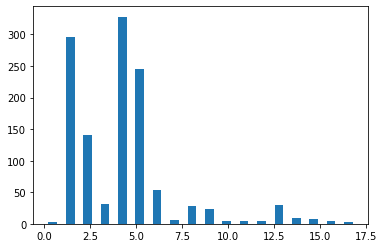

In [ ]:
freq = plt.hist(partition.values(), bins = len(set(partition.values())), rwidth = 0.5)

community_size = pd.DataFrame(freq[0])
community_size.rename(columns = {0:'Community Size'}, inplace = True) #renaming column
com_trilogy = pd.DataFrame.from_dict({partition.get('Anakin_Skywalker'): [community_size.iloc[partition.get('Anakin_Skywalker'),0],'pre'], \
    partition.get('Luke_Skywalker'): [community_size.iloc[partition.get('Luke_Skywalker'),0],'or'],\
    partition.get('Rey_Skywalker'): [community_size.iloc[partition.get('Rey_Skywalker'),0],'seq']}, orient='index')
com_trilogy.rename(columns = {0:'Community Size', 1:'Trilogy'}, inplace = True)
com_trilogy

com_dict = dict(zip(list(com_trilogy['Community Size'].keys()), [[key for key, val in partition.items() if val == com] for com in com_trilogy['Community Size'].keys()]))

In [ ]:
corpus_root_com = os.getcwd() + '/data/Communities/'
file_list_com = pd.Series([str(key) + '.txt' for key in com_dict.keys()])
corpus_com = pcr(corpus_root_com, file_list_com)
com_top = [corpus_com.words(c) for c in corpus_com.fileids()]

In [ ]:
id2word = corpora.Dictionary(com_top)

common_corpus = [id2word.doc2bow(index) for index in com_top]

model = gensim.models.LdaMulticore(corpus = common_corpus, id2word = id2word, num_topics = 3)
cm = CoherenceModel(model=model, corpus=common_corpus, coherence='u_mass')
coherence = cm.get_coherence()

model.show_topics(num_topics=3, num_words = 6)

[(0,
  '0.013*"jedi" + 0.007*"first" + 0.007*"force" + 0.007*"order" + 0.007*"skywalker" + 0.006*"would"'),
 (1,
  '0.009*"jedi" + 0.008*"first" + 0.007*"skywalker" + 0.006*"force" + 0.006*"order" + 0.005*"would"'),
 (2,
  '0.010*"jedi" + 0.007*"force" + 0.007*"first" + 0.007*"skywalker" + 0.005*"order" + 0.005*"vader"')]

# Sentiment analysis

We wish to look at sentiment for each of the characters both based on the wikipages and the scripts. The two methods we will use for sentiment analysis are LabMT and VADER. The LabMT is a dictionary-based approach, which means we will only be able to compute the sentiment for words in the LabMT dataset. This limits the LabMT's ability to deal with connection words such as negation. The VADER method is a combination of a rule-based approach and a dictionary-based approach. The combination means VADER will modify the polarity of a word based on the surrounding words. Due to the rule-based approach the conjunction words, which were ignored in the LabMT method, will also be evaluated. 

VADER is created for social media features for punctuation, emojis and slang are added.

We will save the characters and their corresponding wikipage inside a dictionary. To do this we will loop over all characters and extract the text from [WOOKIEEPEDIA](https://starwars.fandom.com/wiki/Main_Page).

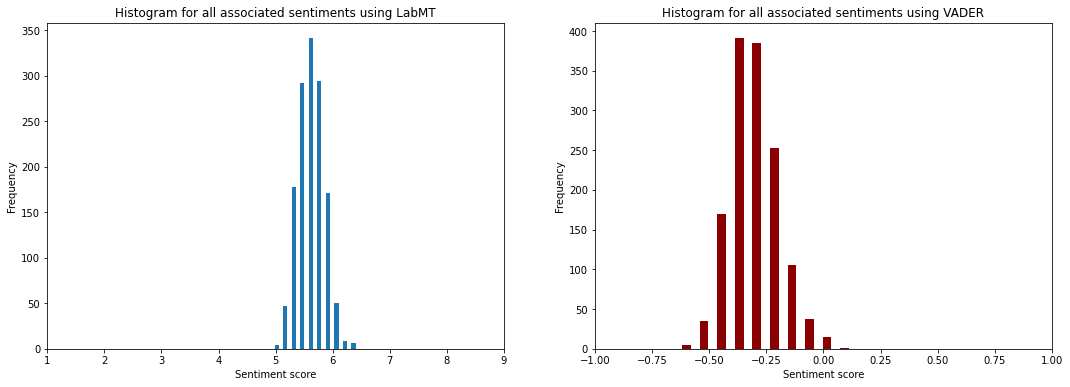

In [3]:
figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.hist(dict_LabMT.values(), bins=10, align='left', rwidth = 0.5)
plt.title('Histogram for all associated sentiments using LabMT')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([1,9])

plt.subplot(1,2,2)
plt.hist(dict_VADER.values(), bins=10, align='left', rwidth = 0.5, color='darkred')
plt.title('Histogram for all associated sentiments using VADER')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.xlim([-1,1])

plt.show()

The plot above shows the distribution of sentiment for all characters using two different methods. It is important to note, that the scale and mean are defined differently for the two methods. 

On the left-hand side, we see the results from LabMT. The average for this method is 5 and we can see that the majority of the characters are slightly above average. But the values are close to 5 which means they will still be categorized as neutral. On the right-hand side, we have the distribution created by the VADER method. Here we see that the mean is zero and the vast majority are below 0. Furthermore, we see that some will be classified as negative since they have a score lower than -0.5. 

As we can see the two methods results in very different results. This is due to the different approaches these two methods use. The VADER uses a combination of the rule-based and dictionary-based approach which means more aspects are picked up from text files, such as negation and conjunctions. Furthermore, we see that the VADER shows, that there are characters who will be categorized as negative. A reason for the sentiment analysis score being low could be because the Star Wars movies are talking about war with a lot of weapons and describing evil and good. Since most of the words related to war are categorized as negative this explains why the sentiment is tilted towards negative.

The VADER method categorized some characters not as neutral, we will take a closer look at these characters. 

In [ ]:
# Sort the dictionary based on VADER score 
sorted_VADER = dict(sorted(dict_VADER.items(), key=lambda item: item[1]))

# Print the top 5 most negative characters 
for i in range(5):
    print(f"{list(sorted_VADER.keys())[i]} has VADER sentiment vlues of {np.round(list(sorted_VADER.values())[i],2)}")

Grievous has VADER sentiment vlues of -0.6
Mot-Not_Rab has VADER sentiment vlues of -0.56
Edcel_Bar_Gane has VADER sentiment vlues of -0.55
Po_Nudo has VADER sentiment vlues of -0.53
IG-101 has VADER sentiment vlues of -0.53


The top 5 most negative characters from the VADER methods are all categorized as having a negative sentiment. The most negative character is Grievous who was a warlord. He has a detailed wikipage describing through all the things he has done, which are all war related. For the rest of the top 5 most negative characters, by inspecting their corresponding wikipage we see that the wikipages are short. This could result in the sentiment being lower, since all Star Wars character most likely have war related words, thus when the wiki page is short these will weigh more.